In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
simData = pd.read_csv("data/earth_orbit_simulation.csv")
simData.head()


,time,x,y,vx,vy
0,0,1.496000e+11,0.000000e+00,0.000000,29783.000000
1,21600,1.495972e+11,6.433128e+08,-128.124172,29783.000000
2,43200,1.495917e+11,1.286614e+09,-256.249530,29782.449023
3,64800,1.495834e+11,1.929891e+09,-384.373707,29781.347048
4,86400,1.495723e+11,2.573132e+09,-512.494335,29779.694065


In [8]:
# Create features and target variables
# Features: time, x, y
# Time is the independent variable, and x and y are the dependent variables
time = simData[['time']]
x_target = simData['x']
y_target = simData['y']

In [9]:
# Scale the features
scaler = MinMaxScaler()
time_scaled = scaler.fit_transform(time)

# Train-test split
X_train, X_test, y_train_x, y_test_x = train_test_split(time_scaled, x_target, test_size=0.2, random_state=42)
_, _, y_train_y, y_test_y = train_test_split(time_scaled, y_target, test_size=0.2, random_state=42)

# Reshape for LSTM input
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [10]:
# Define a new, deeper model for X
model_x = Sequential()
model_x.add(LSTM(50, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model_x.add(LSTM(50, activation='tanh'))
model_x.add(Dense(1))
model_x.compile(optimizer='adam', loss='mse')

# Define a new, deeper model for Y
model_y = Sequential()
model_y.add(LSTM(50, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model_y.add(LSTM(50, activation='tanh'))
model_y.add(Dense(1))
model_y.compile(optimizer='adam', loss='mse')

c:\Users\edmar\OneDrive\Documents\CSUF\Machine Learning\Solar-System-Dyamics\ofile\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
# Large batch size and early stopping
# Train X model
history_x = model_x.fit(X_train, y_train_x, epochs=300, batch_size=32, validation_split=0.2, verbose=1)

# Train Y model
history_y = model_y.fit(X_train, y_train_y, epochs=300, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 11496014509615494463488.0000 - val_loss: 11266243108426865442816.0000
Epoch 2/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11477973089508248256512.0000 - val_loss: 11266243108426865442816.0000
Epoch 3/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10841730429851201961984.0000 - val_loss: 11266243108426865442816.0000
Epoch 4/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11247670263563589517312.0000 - val_loss: 11266243108426865442816.0000
Epoch 5/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11198191466257483563008.0000 - val_loss: 11266243108426865442816.0000
Epoch 6/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11379131462586441138176.0000 - val_loss: 11266243108426865442816.0000
Epoch 7/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11251403747654679658496.0000 - val_loss: 11266243108426865442816.0000
Epoch 8/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11325594922016074366976.0000 - val_los

In [12]:
# Predict X and Y coordinates using the tuned deeper LSTM models
y_pred_x_lstm_tuned = model_x.predict(X_test)
y_pred_y_lstm_tuned = model_y.predict(X_test)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [15]:
# Inverse-transform the scaled data back to real-world values
# Unscale the predictions and the test data
X_test_real = scaler.inverse_transform(X_test[:, 0, :])
# X_test_real = X_test_real.flatten()  # Flatten to 1D array
y_test_x_real = y_test_x.values

y_test_y_real = y_test_y.values

y_pred_x_real = y_pred_x_lstm_tuned.flatten()
y_pred_y_real = y_pred_y_lstm_tuned.flatten()


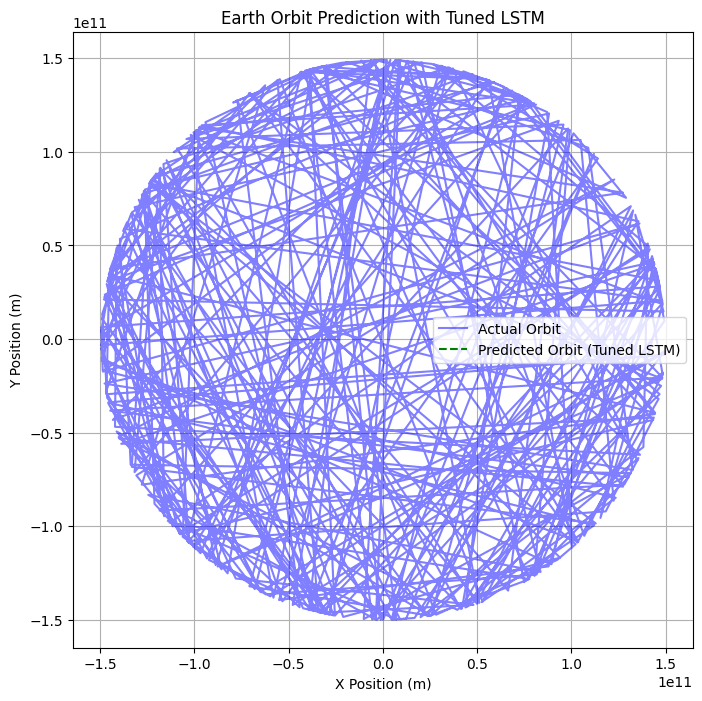

In [16]:
# Plot the actual vs tuned LSTM orbit
plt.figure(figsize=(8, 8))

# Actual Orbit
plt.plot(y_test_x_real, y_test_y_real, label='Actual Orbit', color='blue', alpha=0.5)

# Predicted Orbit (Tuned LSTM)
plt.plot(y_pred_x_real, y_pred_y_real, label='Predicted Orbit (Tuned LSTM)', color='green', linestyle='--')

plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Earth Orbit Prediction with Tuned LSTM')
plt.legend()
plt.grid(True)
plt.show()


In [17]:
# Evaluate R² and MSE for the tuned LSTM model
print("Tuned LSTM R² X:", r2_score(y_test_x_real, y_pred_x_real))
print("Tuned LSTM MSE X:", mean_squared_error(y_test_x_real, y_pred_x_real))

print("Tuned LSTM R² Y:", r2_score(y_test_y_real, y_pred_y_real))
print("Tuned LSTM MSE Y:", mean_squared_error(y_test_y_real, y_pred_y_real))


Tuned LSTM R² X: -0.004825062550978254
Tuned LSTM MSE X: 1.0672899110134834e+22
Tuned LSTM R² Y: -1.6058826857845432e-05
Tuned LSTM MSE Y: 1.1689241123803338e+22
